## ECON 323 Final Project
### An Analysis of Airbnb Prices Across Popular Countries in Europe


Karina Grewal (section 004), Hrithik Soni (section 003)

## Introduction
We will be looking into predicting the prices of Airbnb's in popular European destinations based on a variety of factors. As an additional quesiton we will be looking into training a classification model that tries to classify which city the Airbnb is in, based on some given factors. The dataset also includes prices when it is the weekend in comparison to weekdays. Therefore this analysis will provide much insight into social/geological factors that reveal booking trends in Airbnb's across Europe. 

## Data Description
This dataset has a wide variety of different variables to look at and create models on. Here we have a list of the variables and their descriptions. 

**The Response Variable**
* realSum (the total price of the listing)

**Independent Variables**
* room_type: the type of the accommodation 
* room_shared: dummy variable for shared rooms
* room_private: dummy variable for private rooms
* person_capacity: the maximum number of guests 
* host_is_superhost: dummy variable for superhost status
* multi: dummy variable if the listing belongs to hosts with 2-4 offers
* biz: dummy variable if the listing belongs to hosts with more than 4 offers
* cleanliness_rating: cleanliness rating
* guest_satisfaction_overall: overall rating of the listing
* bedrooms: number of bedrooms (0 for studios)
* dist: distance from city centre in km
* metro_dist: distance from nearest metro station in km
* attr_index: attraction index of the listing location
* attr_index_norm: normalised attraction index (0-100)
* rest_index: restaurant index of the listing location
* rest_index_norm: normalised restaurant index (0-100)
* lng: longitude of the listing location
* lat: latitude of the listing location

We decided to remove the following variables:

1. `guest_satisfaction_overall` as there is a chance that this rating may affect both the price of the Airbnb and the other variables in our dataset. For example if a low satisfaction score is given there is a chance that this person had a bad experience with the host and now will give a low score to the host, preventing them from becoming a superhost. To avoid this complication we are removing this variable.
2. `attr_index` and `rest_index` are being removed as we will use their normalized values listed in `attr_index_norm` and `rest_index_norm`.
3. We will also be removing `lat` and `lng` from our analysis. In our analysis we will be looking into creating a model that will try to correctly classify which city an Airbnb is listed in given a list of values for the independent variables. Therefore as the cities given in this dataset are physically very far apart these variables are essentially an answer key for the model. Therefore we remove these variables from our entire analysis. 


## Methods: Prediction
We will be using four types of models in order to try to accurately predict the price of an Airbnb given various other values. 
1. Ordinary Least Squares Regression
    * This is the simplest of our models that will construct a linear relationship between the predictors given and the response variable being Airbnb price. 
2. Lasso Regression
    * This linear model uses a L1 regularization method to find a penalty parameter to improve the predictive power from the regular linear model by constraining some variables. The L1 technique allows some coefficients to shrink to zero.  Thereby this model does variable selection *and* regularization to make the most optimal model. 
3. Ridge Regression
    * Ridge uses a L2 technique to find a penalty parameter to constrain variables within the model, however it does not perform variable selection as it does not shrink those coefficients to zero.  
4. Elastic-Net
    * Elastic Net is a combination of Ridge and Lasso in that it performs regularization and variable selection at the same time by using a combination of L1 and L2 techniques. 

### Reading data

Loading necessary packages

In [53]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import glob, os
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.linear_model import (
    Lasso, Ridge, ElasticNetCV
)
from sklearn.model_selection import (
    GridSearchCV, RepeatedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
)
from sklearn.metrics import (
    mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from shapely.geometry import Point
from pathlib import Path
from itertools import cycle

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

Downloading datasets to a local folder

In [8]:
od.download("https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities")

Skipping, found downloaded files in "./airbnb-prices-in-european-cities" (use force=True to force download)


Our data set is spread out across many different files so a for loop was written to first read each file and then append the data. The files are separated by city and by whether the data is from a weekday or a weekend. Therefore two new columns were added to indicate which city the data line came from and which time period. This dataset also provides us with various columns for dummy variables. The following columns are dummy variables and therefore may be excluded from some exploratory data analysis. 

1. `room_share`  & `room_private` are dummy variables for the column `room_type`
2. `multi` & `biz` are dummy variables to indicate how many offers the host has. 

In [9]:
#trying to download all datasets
path = r'airbnb-prices-in-european-cities' 

# Get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories
dfs = list()

#appending all the different files into dataframes by filename of form city_time
for i, f in enumerate(files):
    data = pd.read_csv(f, index_col=0).assign(City=os.path.basename(f).split('.')[0])
    dfs.append(data)

#Combining into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#splitting the file name into two columns with city name and weekday/weekend time period separate
df[['city', 'time']] = df.City.str.split("_", expand = True)
df = df.drop('City', axis=1)

#preview
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays


Checking if there are any missing data in the dataset, we see that we have a complete dataset and therefore we can move forward with our analysis.

In [10]:
print(df.isnull().sum())

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
time                          0
dtype: int64


## Exploratory Data Analysis

#### Creating a European Map of where the data points came from

In [11]:
#Creating coordinates for geopandas to read
df["Coordinates"] = list(zip(df.lng, df.lat))
df["Coordinates"] = df["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry="Coordinates")

# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

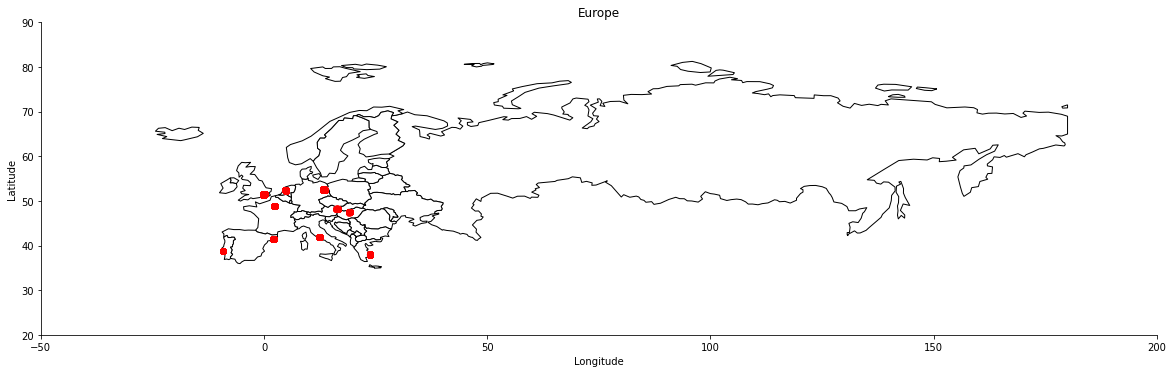

In [12]:
# Plot the cities onto the map
fig, gax = plt.subplots(figsize=(20,20))

world.query("continent == 'Europe'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
gax.set_title('Europe')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.xlim(-50, 200)
plt.ylim(20, 90)

# Plotting the city names
# for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['city']):
#     gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')
    
plt.show()

### Counts of values available to us per city

(0.0, 11000.0)

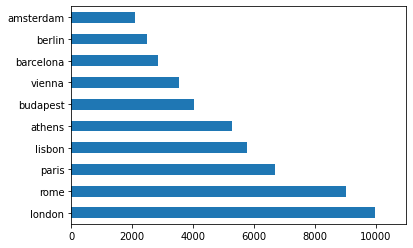

In [13]:
df["city"].value_counts().plot(kind = "barh")

plt.xlim(0, 11000)

We see that London has the most data points while Amsterdam has the least amount of data points in our given data set. 

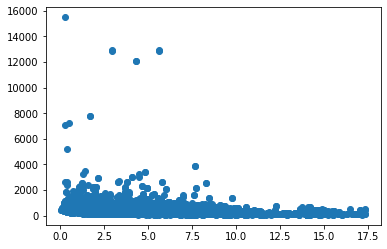

In [14]:
fig, ax = plt.subplots()

ams_rs = df.loc[df["city"] == "london"]["realSum"]
ams_cr = df.loc[df["city"] == "london"]["dist"]

ax.scatter(ams_cr, ams_rs)

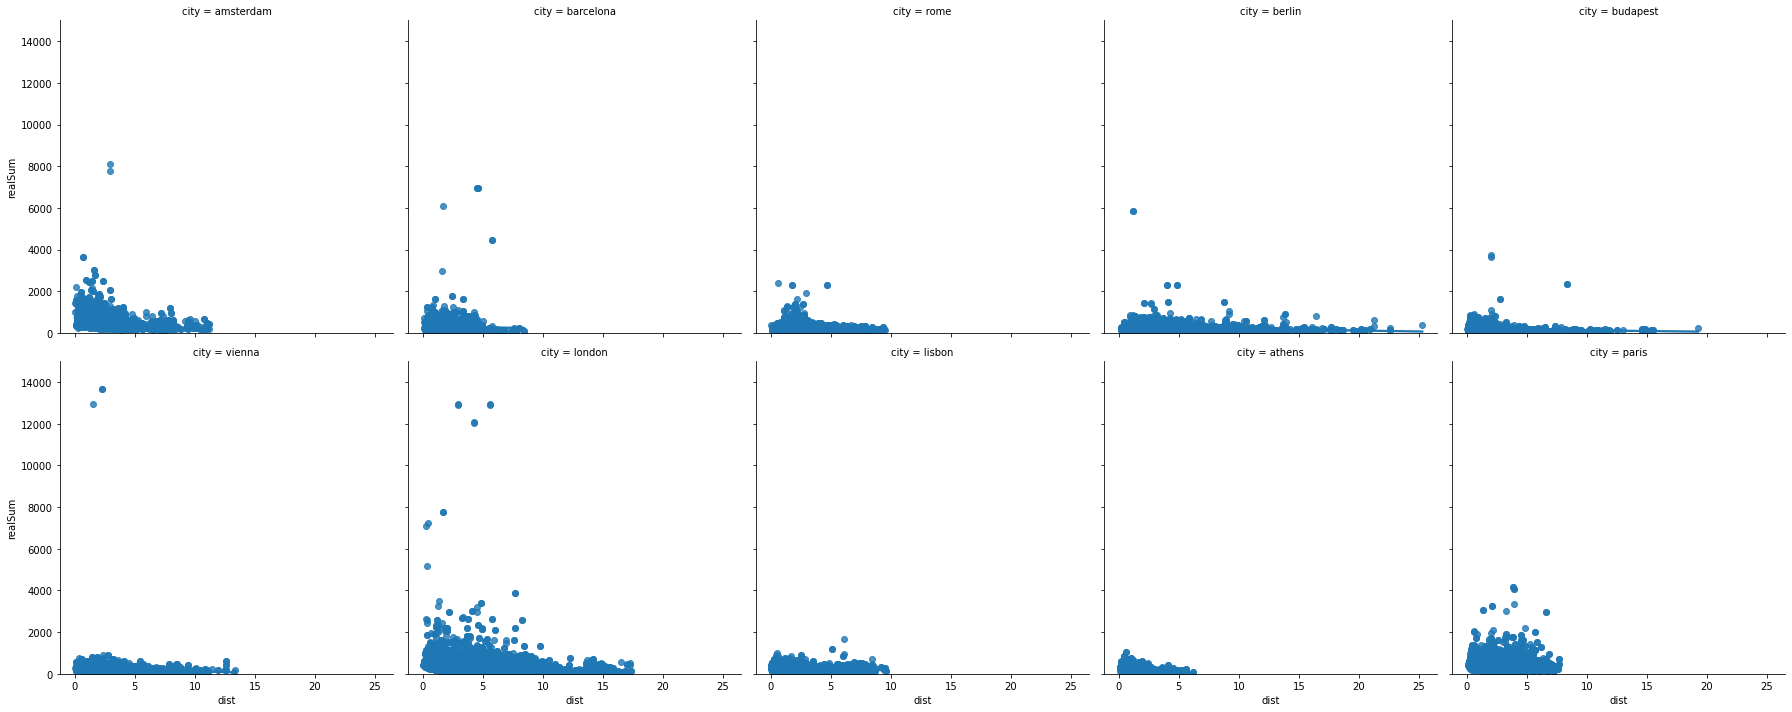

In [15]:
x = sns.lmplot(data=df, x='dist', y = 'realSum', col='city', col_wrap=5)
x.set(ylim = (0, 15000))

### Average price per city

<AxesSubplot: xlabel='city'>

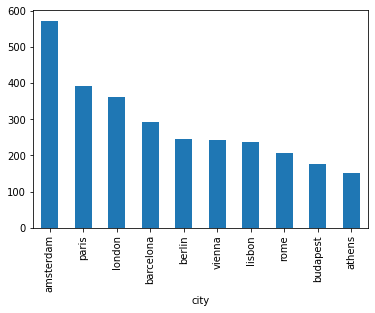

In [16]:
avg_price = df.groupby("city")["realSum"].mean()

avg_price.sort_values(ascending=False).plot.bar()

We see that there is a clear trend that some cities on average have a higher average prices

### Distribution of Prices

The models we discuss above are linear models, and they require the assumption that the distribution of the data that is being regressed on must be approximately normal. Therefore we plot the distribution to check that this assumption is valid.

(1.0, 3000.0)

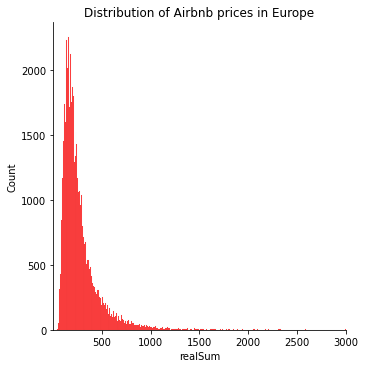

In [17]:
y = sns.displot(df['realSum'], color = 'r')
y.set(title = "Distribution of Airbnb prices in Europe")
plt.xlim(1,3000)

The plot above shows that the distribution of airbnb prices across Europe is right skewed and is not normal, we try a log transformation on the price to see if we can get a more normal distribution. 

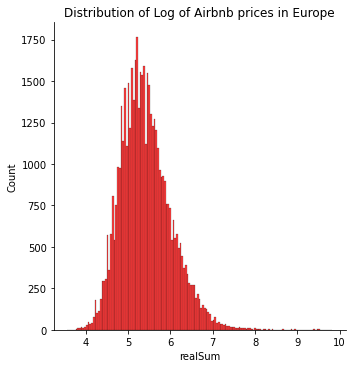

In [18]:
sns.displot(np.log(df['realSum']), color = 'r').set(title = "Distribution of Log of Airbnb prices in Europe")

Transforming the prices to the log scale shows that the distribution is now approximately normal. The log transformed data satisfies the normality assumption of our linear models, so we will move forward in our analysis using the transformed data.

Text(0, 0.5, 'Log Airbnb Cost')

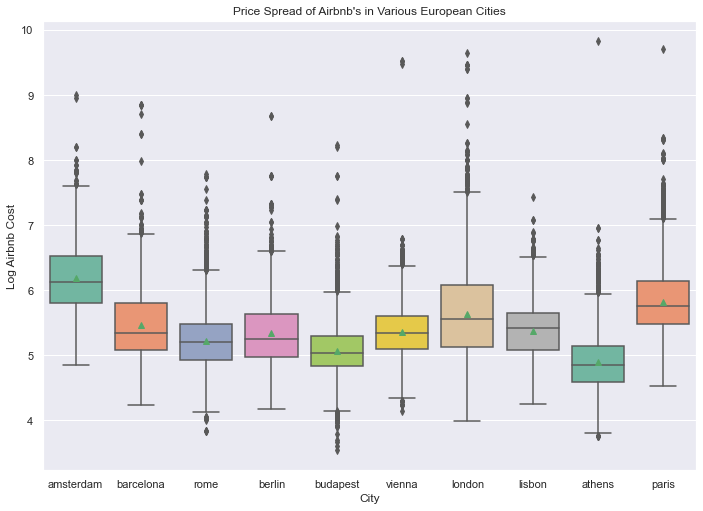

In [19]:
df2 = df.copy()
df2["realSum"] = np.log(df2["realSum"])

sns.set(rc={'figure.figsize':(11.7,8.27)})


sns.boxplot(x="city", y="realSum", data=df2, palette="Set2", showmeans=True)
plt.title("Price Spread of Airbnb's in Various European Cities")
plt.xlabel("City")
plt.ylabel("Log Airbnb Cost")

The lines in the middle of the boxes indicate the medians, while the green triangle showcases the mean Airbnb price for that city on the samples collected. Here we have taken the log of the Airbnb Prices in order to make the data normal as it was shown to be right skewed initially.

### Correlation heat map

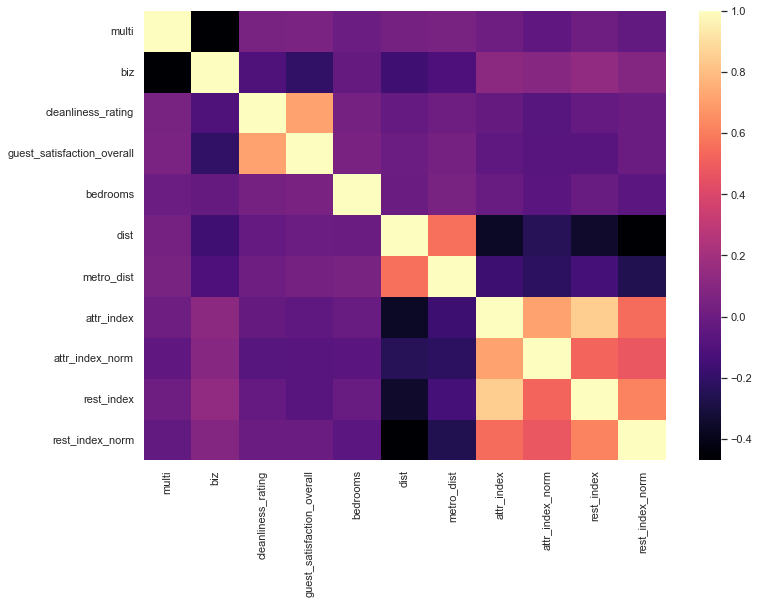

In [20]:
# Heatmap
df_heatmap = df.select_dtypes(include=np.number).iloc[:,2:-2]
df_heatmap

sns.heatmap(df_heatmap.corr(), annot = False, cmap = 'magma')
plt.show()

Here we see that many variables are correlated with each other. For example `attr_index`, `attr_index_norm`, `rest_index`, `rest_index_norm`. These variables correspond to a score and their normalized versions of that score (moved onto a scale of 0-100). We see that the normalized version of the variables have lower correlation with each other and therefore we will use the two normalized variables and drop the other two in our analysis further.  

#### Plotting Continuous Variables

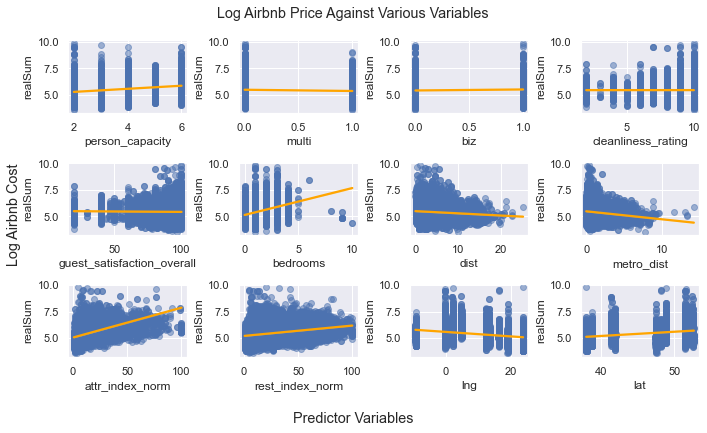

In [21]:
display_df = df[['realSum','person_capacity','multi', 'biz', 'cleanliness_rating', 
                   'guest_satisfaction_overall', 'bedrooms', 'dist',
                   'metro_dist','attr_index_norm', 'rest_index_norm', 'lng', 'lat']]

fig, ax = plt.subplots(3, 4 ,figsize=(10,6))

#for loop to display a different predictor on each subplot
for i,col in enumerate(display_df.columns[1:]):
    if (i < 4):
        x = 0
        sns.regplot(x=display_df[col], y=np.log(display_df['realSum']), ax=ax[x, i], scatter_kws={"alpha": 0.5},line_kws={"color": "orange"})
    elif (i < 8):
        x = 1
        sns.regplot(x=display_df[col], y=np.log(display_df['realSum']), ax=ax[x, i-4], scatter_kws={"alpha": 0.5},line_kws={"color": "orange"})
    elif (i < 12):
        x = 2
        sns.regplot(x=display_df[col], y=np.log(display_df['realSum']), ax=ax[x, i-8], scatter_kws={"alpha": 0.5},line_kws={"color": "orange"})

        
fig.suptitle('Log Airbnb Price Against Various Variables')
fig.supxlabel("Predictor Variables")
fig.supylabel("Log Airbnb Cost")
fig.tight_layout()

plt.show()

We see from the orange line whether or not the log price has a postive, negative or no relationship with the log Airbnb price. A positive relationship will have an upward sloping linear regression line, while a negative relationship will be shown with a downward sloping line. We can also see that there are many variables that are binary or that have multiple levels rather than being continuous. For example `multi` and `biz` are binary. Therefore we will explore these variables with more box plots. 

### Plotting Discrete Variables against Price

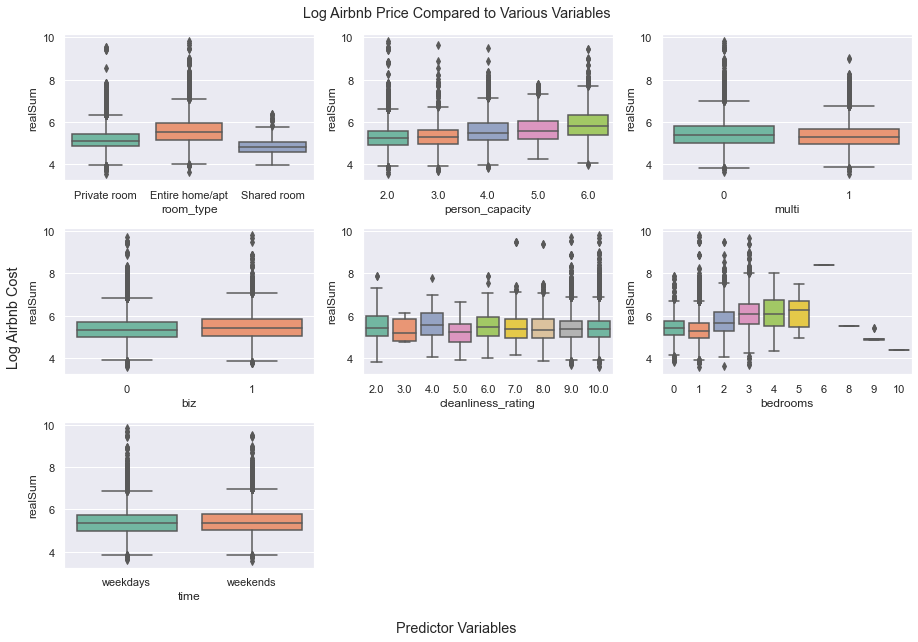

In [22]:
discrete_df = df[['realSum','room_type', 'person_capacity','multi', 'biz', 'cleanliness_rating', 
                   'bedrooms', 'time']]

fig, ax = plt.subplots(3, 3 ,figsize=(13,9))

#delete extra ax
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

#for loop to display a different predictor on each subplot
for i,col in enumerate(discrete_df.columns[1:]):
    if (i < 3):
        x = 0
        sns.boxplot(x=discrete_df[col], y=np.log(discrete_df['realSum']), palette="Set2", ax=ax[x,i])
    elif (i < 6):
        x = 1
        sns.boxplot(x=discrete_df[col], y=np.log(discrete_df['realSum']), palette="Set2", ax=ax[x,i-3])
    elif (i < 12):
        x = 2
        sns.boxplot(x=discrete_df[col], y=np.log(discrete_df['realSum']), palette="Set2", ax=ax[x,i-6])


fig.suptitle('Log Airbnb Price Compared to Various Variables')
fig.supxlabel("Predictor Variables")
fig.supylabel("Log Airbnb Cost")
fig.tight_layout()

plt.show()

Here we see that the medians for every levels across all the predictor variables are quite similar as the boxplots overlap each other quite a bit. 

## Methods

### Prediction

Splitting dataset into training and testing datasets (75/25 split) and creating dummy variable for categorical explanatory variables.

In [23]:
x = df.drop(["Coordinates", "realSum", "attr_index", "rest_index", 
             "guest_satisfaction_overall", "lat", "lng"], axis=1)

X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)

Y = np.log(df["realSum"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

#### 1. Full OLS

Fitting a linear regression model on training dataset (including all variables)

In [24]:
airbnb_ols = linear_model.LinearRegression()
airbnb_ols.fit(x_train, y_train)

LinearRegression()

Using OLS model to get fitted values on testing dataset

In [25]:
airbnb_test_OLS = airbnb_ols.predict(x_test)

Computing out of sample error (Test MSE)

In [26]:
def sample_mse(y_train, y_test):
    return np.sum((y_train-y_test)**2)/len(y_train)

In [27]:
airbnb_OLS_mse = sample_mse(y_test, airbnb_test_OLS)
airbnb_OLS_mse

0.12762078376380065

#### 2. Lasso Regression

Visualizing LASSO path: LASSO coefficients over alpha values

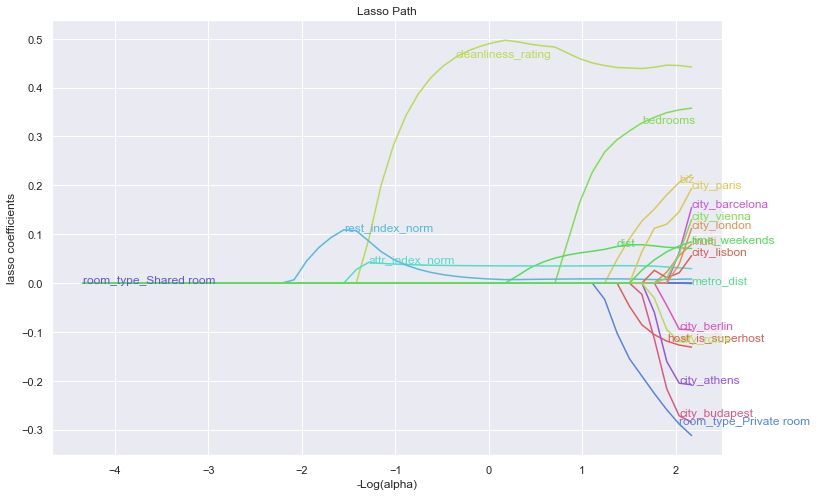

In [28]:
from itertools import cycle
alphas = np.exp(np.linspace(10, -5, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(x_train, y_train, alphas=alphas, max_iter=10000)
colors = sns.color_palette("hls", 15)

fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, x_train):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)
    
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=sample_mse(y_train, mod.predict(X_train)),
        mse_test=sample_mse(y_test, mod.predict(X_test))
    )

Performing 5-fold cross-validation to find the optimal value of $\alpha$ based on MSE

In [29]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           x_train, x_test, y_train, y_test)
                    for alpha in alphas])

mse["log_alpha"] = -np.log10(alphas)

mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]

optimal_log_alpha_lasso = mse.iloc[mse["cv"].idxmin()]["log_alpha"]
optimal_log_alpha_lasso

2.171472409516259

Converting $\alpha$ back to original scale

In [30]:
optimal_alpha_lasso = 1/10**optimal_log_alpha_lasso
optimal_alpha_lasso

0.006737946999085466

Fitting LASSO model using optimal $\alpha$ value

In [31]:
lasso_best = Lasso(alpha=optimal_alpha_lasso)
lasso_best.fit(x_train, y_train)

Lasso(alpha=0.006737946999085466)

Computing out-of-sample error (Test MSE)

In [32]:
airbnb_lasso_mse = sample_mse(y_test, lasso_best.predict(x_test))
airbnb_lasso_mse

0.15762360489848293

#### 3. Ridge Regression

Normalizing the predictor variables (only continuous)

In [107]:
list_numerical = X.columns[3:11]

scaler = StandardScaler().fit(x_train[list_numerical]) 

x_train[list_numerical] = scaler.transform(x_train[list_numerical])

x_test[list_numerical] = scaler.transform(x_test[list_numerical])

Performing 5-fold cross-validation to find the optimal value of $\alpha$ based on MSE

In [34]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Ridge(alpha=alpha, max_iter=50000),
                           x_train, x_test, y_train, y_test)
                    for alpha in alphas])

mse["log_alpha"] = -np.log10(alphas)

mse["cv"] = [-np.mean(cross_val_score(linear_model.Ridge(alpha=alpha, max_iter=50000),
                                  x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]

optimal_log_alpha_ridge = mse.iloc[mse["cv"].idxmin()]["log_alpha"]
optimal_log_alpha_ridge

0.9870329134164817

Converting $\alpha$ back to original scale

In [35]:
optimal_alpha_ridge = 1/10**(optimal_log_alpha_ridge)
optimal_alpha_ridge

0.10303080346176412

Computing out-of-sample error (Test MSE)

In [36]:
ridge_best = Ridge(alpha=optimal_alpha_ridge)
ridge_best.fit(x_train, y_train)

airbnb_ridge_mse = sample_mse(y_test, ridge_best.predict(x_test))
airbnb_ridge_mse

0.1276209672601394

#### 4. Elastic Net

Performing 5-fold cross-validation to find the optimal value of $\alpha$ and L1 ratio based on MSE

In [118]:
parameters = dict()
parameters['alpha'] = np.exp(np.linspace(10, -5, 100))
parameters['l1_ratio'] = np.arange(0.01, 1, 0.01)

elastic_model = ElasticNet()

elastic_cv = RandomizedSearchCV(elastic_model, params, n_iter = 100, scoring="neg_mean_squared_error", cv=5, 
                                verbose=0, refit=False)

elastic_cv.fit(x_train, y_train)

optimal_l1_ratio = elastic_cv.best_params_.get('l1_ratio')
optimal_elastic_alpha = elastic_cv.best_params_.get('alpha')

print('optimal alpha: %f' % optimal_elastic_alpha)
print('optimal l1_ratio_: %f' % optimal_l1_ratio)

optimal alpha: 0.000010
optimal l1_ratio_: 0.210000


Computing out-of-sample error (Test MSE)

In [96]:
elastic_best = ElasticNet(alpha = optimal_elastic_alpha, l1_ratio = optimal_l1_ratio)
elastic_best.fit(x_train, y_train)

elastic_best_mse = sample_mse(y_test, elastic_best.predict(x_test))

print(airbnb_elastic_mse)

0.13970808689419648


#### 5. Neural Networks

Using 5-fold cross-validation to find the optimal configuration for our neural network model

In [119]:
neural_model = neural_network.MLPRegressor(hidden_layer_sizes=(40, 100),
                                           activation = 'relu',
                                           solver = 'adam')

neural_model.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=(40, 100))

Due to high computation time, we limit out neural network to two hidden layers. Since our response variable is continuous we choose from identity (linear) or relu activation methods.

In [120]:
config_grid = {
    'hidden_layer_sizes': [(30,75), (20,50), (10,25)],
    'activation': ['relu', 'identity'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

optimal_grid = GridSearchCV(neural_model, config_grid, n_jobs= -1, cv=5)
optimal_grid.fit(x_train, y_train)

print(optimal_grid.best_params_) 

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (30, 75), 'learning_rate': 'adaptive', 'solver': 'adam'}


Computing out-of-sample error (Test MSE)

In [123]:
airbnb_neural_mse = sample_mse(y_test, optimal_grid.predict(x_test))
airbnb_neural_mse

0.11200454501729057

### Comparing All Predictive Models
First we plot the predictor coefficients from different models on the same graph for comparison.

In [ ]:
#plot size
plt.figure(figsize = (10, 10))

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='black',label=r'Lasso Regression')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#add plot for ridge model
plt.plot(list(x_train), ridge_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='red',label='Ridge Regression')

#add plot for elastic net model
plt.plot(list(x_train), elastic_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='blue',label='Elastic-Net Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Linear regression, Lasso, Ridge, and Elastic-net models")
plt.show()

Here we see that the predictors that have parameters that deviate from zero are mostly concentrated on the right side of the graph. Those variables correspond to the dummy variable that indicates which city the Airbnb came from with the base indicator being Amsterdam. That means that when any city dummy variable has a parameter, with all other parameters kept constant, we are looking at that cities Airbnb price in comparison to the baseline city: Amsterdam. 

#### Counting Number of Non-zero Coefficients

First we print a table of the coefficients shown in the graph above

In [91]:
def series_coef(mod):
    "Prints a Panadas Series that lists all the Coefficients for a specific model"
    return pd.Series(dict(zip(list(x_train), mod.coef_)))

coefs = pd.DataFrame(dict(lasso=series_coef(lasso_best), 
                          linreg=series_coef(airbnb_ols),
                          ridge = series_coef(ridge_best),
                          elastic = series_coef(elastic_best)))

coefs.round(3)
print(coefs)

model_coefs = [["Full OLS", len(list(np.nonzero(airbnb_ols.coef_))[0])], 
               ["LASSO", len(list(np.nonzero(lasso_best.coef_))[0])], 
               ["Ridge", len(list(np.nonzero(ridge_best.coef_))[0])],
               ["Elastic Net", len(list(np.nonzero(elastic_best.coef_))[0])]]

model_coefs_df = pd.DataFrame(model_coefs, columns=['Model', 'Number of variables'])
model_coefs_df



                           lasso    linreg     ridge   elastic
host_is_superhost       0.000000  0.016499  0.016495  0.016480
multi                  -0.000000  0.063748  0.063726  0.063655
biz                     0.029951  0.143307  0.143269  0.143156
cleanliness_rating      0.025215  0.039185  0.037672  0.037668
bedrooms                0.233048  0.240323  0.150753  0.150764
dist                    0.001546 -0.011074 -0.026526 -0.026541
metro_dist             -0.000000 -0.017148 -0.014750 -0.014703
attr_index_norm         0.019632  0.012076  0.118033  0.118062
rest_index_norm         0.003073  0.003002  0.053418  0.053434
room_type_Private room -0.420899 -0.519196 -0.249366 -0.249333
room_type_Shared room  -0.000000 -0.792362 -0.067911 -0.067905
city_athens            -0.564525 -1.412358 -1.411758 -1.410073
city_barcelona          0.000000 -0.567125 -0.566566 -0.564985
city_berlin            -0.050630 -0.730136 -0.729574 -0.727982
city_budapest          -0.518151 -1.321066 -1.320475 -1

,Model,Number of variables
0,Full OLS,21
1,LASSO,15
2,Ridge,21
3,Elastic Net,21


Here we count the number of non-zero coefficients, we see that the regularization parameter in lasso has reduced 6 coefficients to zero. The other models use every parameter available. 

In [ ]:
coefs.round(3).abs().astype(bool).sum(axis=0)

#### Comparing MSE

In [117]:
model_mse = [["Full OLS", airbnb_OLS_mse], 
             ["LASSO", airbnb_lasso_mse], 
             ["Ridge", airbnb_ridge_mse],
             ["Elastic Net", airbnb_elastic_mse],
             ["Neural Network", airbnb_neural_mse]
            ]
            
model_mse_df = pd.DataFrame(model_mse, columns=['Model', 'Test-MSE'])
model_mse_df

,Model,Test-MSE
0,Full OLS,0.127621
1,LASSO,0.157624
2,Ridge,0.127621
3,Elastic Net,0.139708
4,Neural Network,0.106197


In [ ]:
airbnb_OLS_mse < airbnb_ridge_mse

The test-MSE (mean squared error) is calculated using the following formula:

$$MSE = \frac{\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2}{n}$$

This statistic calculates how well our models perform on sample-data that was not used to train the model. Therefore it is indicator of how it will perform in general on out-of-sample data. The lower the MSE is, the more accurate it is able to predict Airbnb prices. In our case, the response values are the on the same scale (price) therefore we are able to compare predictive power of our models using their MSE. We see that the ordinary least squares model has the smallest MSE and therefore is the best model to use in order to predict Airbnb prices in Europe. 